# Notebook 4:  Multi Class Classification
__Author: Bibek Poudel__

Using the results from Cross Validation (Notebook 3), I train the neural network on the entire training dataset and see its test performance here 

In [1]:
import time
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import random
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.io import loadmat
%matplotlib inline

In [2]:
# set seeds for reproducibility of results
SEED = 22
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
# Define a dataset class (Required by pytorch)
class MultiDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs_list = inputs
        self.target_list = targets
        assert (len(self.inputs_list) == len(self.target_list))
        
    def __len__(self):
        return len(self.inputs_list)
    
    def __getitem__(self, key):
        input_idx = self.inputs_list[key]
        target_idx = self.target_list[key]
        return [input_idx.astype(np.float32), target_idx.astype(np.float32) ]#.astype(np.long)]

In [4]:
# Define a neural network with a single hidden layer
class model(nn.Module):
    def __init__(self, input_units, hidden_units_l1, hidden_units_l2, output_units):
        super().__init__()
        self.activation = nn.ReLU() # ReLU activation function
        self.fc1 = nn.Linear(input_units, hidden_units_l1) # Hidden units can be specified arbitrarily
        self.fc2 = nn.Linear(hidden_units_l1, hidden_units_l2) # Hidden units can be specified arbitrarily
        self.fc3 = nn.Linear(hidden_units_l2, output_units) # Output units can be specified arbitrarily
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x)) 
        x = self.fc3(x)
        return x

In [5]:
# Performance metric
def akkuracy(ground_truths, predictions):
    num_correct = np.sum(ground_truths==predictions)
    total = ground_truths.shape[0]
    return num_correct*100.0 / total

In [6]:
# Define a method to train neural network model
def train(model, dataloader, optimizer, learning_rate, loss_function, epochs, train_size):
    
    epoch_losses = np.zeros(epochs)
    for epoch in range(epochs):
        predictions =  np.zeros(train_size)
        ground_truths_total= np.zeros(train_size)
        count =0
        
        #print("Epoch:{} ".format(epoch), end = "\t")
        total_loss = 0.0

        for bi, (inputs, targets) in enumerate(dataloader):
            current_size=targets.shape[0]
            ground_truths_total[count: count+current_size] = targets
            
            optimizer.zero_grad()

            outputs = model(inputs)

            #print(outputs)
            #print(targets)
            
            loss = loss_function(outputs.float(), targets.long()) # targets should be long [batch size], outputs are distributed across the classes?
            
            loss.backward()

            optimizer.step()
            
            total_loss+=loss.item()
            
            _, predicted = torch.max(outputs.data, 1) 
            predicted_np = np.squeeze(predicted.cpu().detach().numpy())
            predictions[count: count+current_size] = predicted_np
            
            count+=current_size
        
        avg_batch_loss = round(total_loss/len(dataloader),3)
        #print("Average batch loss:{}".format(avg_batch_loss))
        epoch_losses[epoch] = avg_batch_loss
        torch.save(model, "./saved_models/training_model_multi.pt")
        train_accuracy = akkuracy(ground_truths_total, predictions)
    
    return train_accuracy, epoch_losses

In [7]:
# Define a method to perform model test
def test(trained_model, dataloader, test_size):
    predictions =  np.zeros(test_size)
    ground_truths_total= np.zeros(test_size)
    count =0
    with torch.no_grad():
        for bi, (inputs, ground_truths) in enumerate(dataloader):
            
            outputs = trained_model(inputs)
            _, predicted = torch.max(outputs.data, 1) 
            predicted_np = np.squeeze(predicted.cpu().detach().numpy())
            current_size=ground_truths.shape[0]
            predictions[count: count+current_size] = predicted_np
            ground_truths_total[count: count+current_size] = ground_truths
            count+=current_size

    test_accuracy = akkuracy(ground_truths_total, predictions)
    return test_accuracy, predictions, ground_truths_total


__________________________________________________________
Started Training .... it may take a while...
Training time = 36 seconds
Finished Training, training accuracy at last epoch = 98.17%:

__________________________________________________________


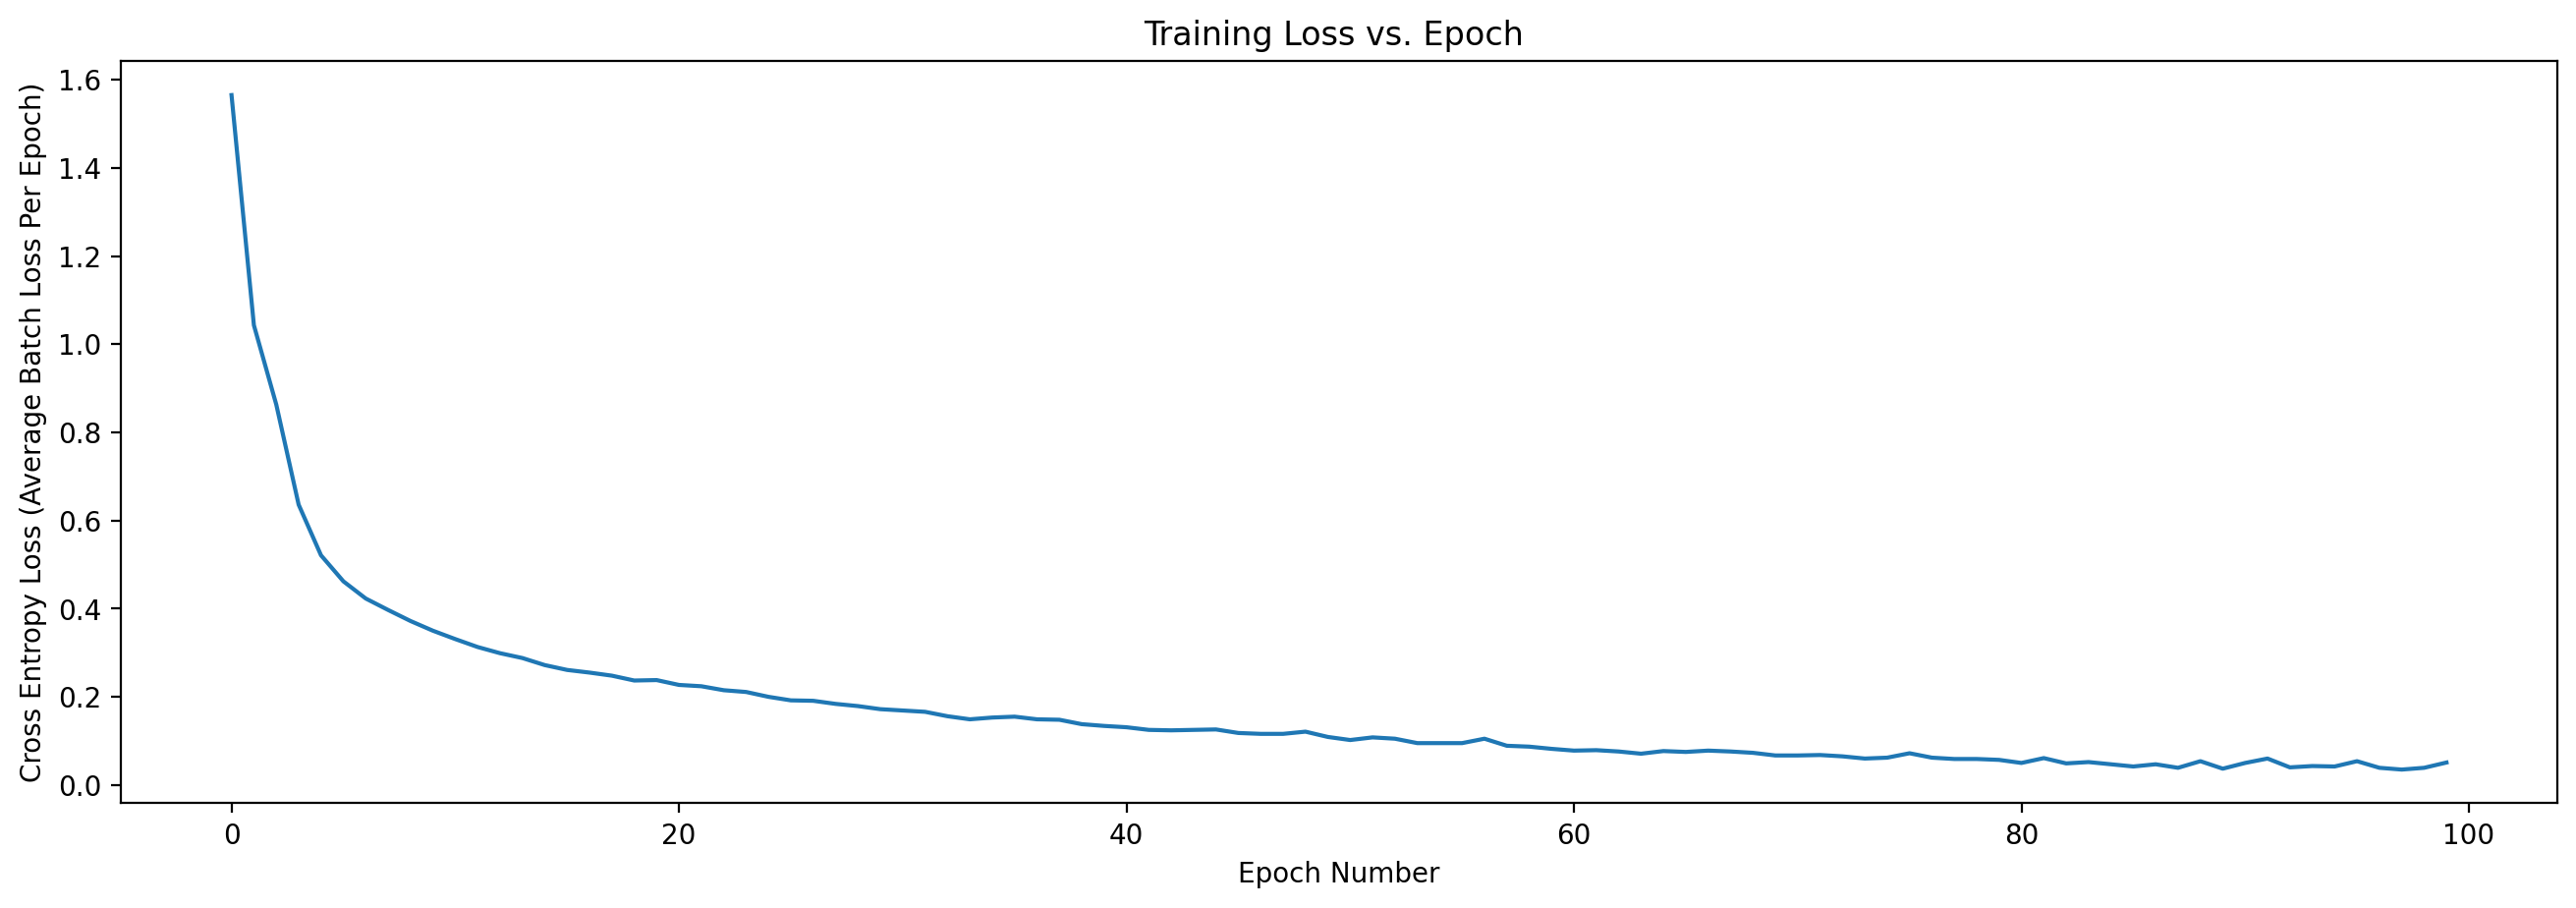


__________________________________________________________
Test accuracy = 85.3 %
Confusion Matrix:
 Total Predicted = 1000


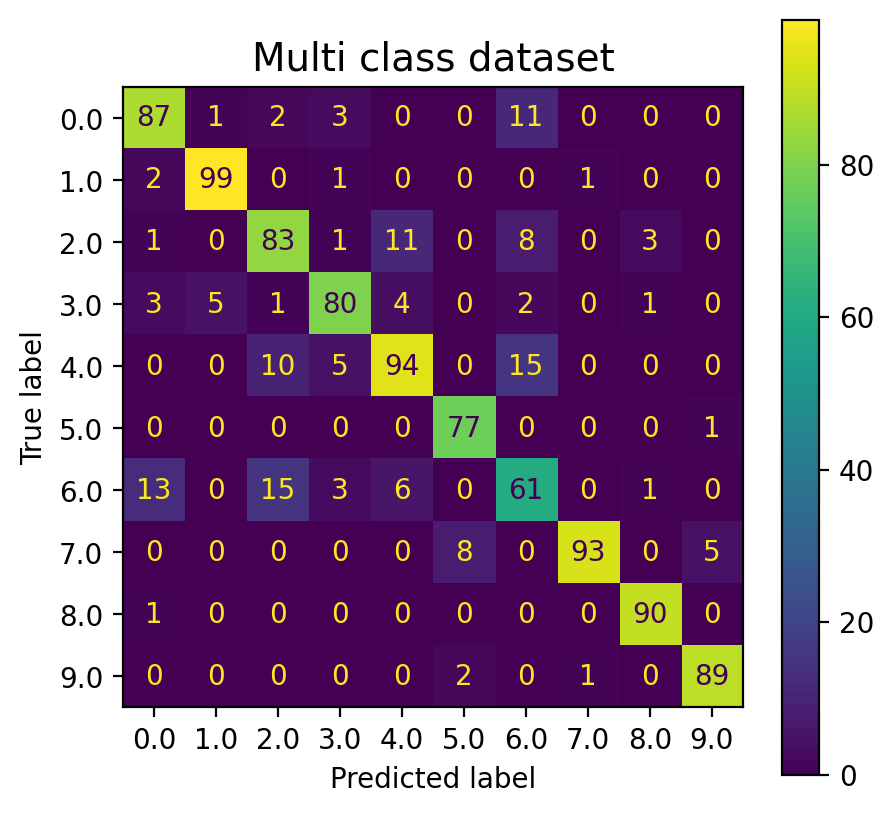


__________________________________________________________


In [8]:
def return_data(dataset_path):
    path_name_end = dataset_path.split('/')[-1]
    d_set = loadmat(dataset_path)
    d_name = path_name_end.split('.')[0]
    data = d_set[d_name]
    return data

datasets = glob.glob('./datasets/multi-class/*.mat')

train_X = return_data(datasets[0])
test_Y = np.squeeze(return_data(datasets[1]))
train_Y = np.squeeze(return_data(datasets[2]))
test_X = return_data(datasets[3])

# Using the results from cross validation
hidden_units_l1 = 100
hidden_units_l2 = 20
output_units = 10

# Training
net = model(train_X.shape[1], hidden_units_l1, hidden_units_l2, output_units).train()

# Using some standard hyper-parameter values for cross validation
epochs =100
loss = nn.CrossEntropyLoss() # Loss function as Cross Entropy
lr = 0.0001 # Learning rate 
optimizer = torch.optim.Adam(net.parameters(), lr = lr) # Optimizer as Adam
BATCH_SIZE = 32


train_dataset = MultiDataset(train_X, train_Y)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=None,
                                           shuffle=False)

print("\n__________________________________________________________")
print("Started Training .... it may take a while...")
start = time.time()
train_acc,epoch_losses = train(net, train_dataloader, optimizer, lr, loss, epochs,train_Y.shape[0])
print("Training time = {} seconds".format(round(time.time() - start),3))
print("Finished Training, training accuracy at last epoch = {}%:".format(round(train_acc,3)))
print("\n__________________________________________________________")
# Plot the training profile
fig, ax = plt.subplots(figsize=(16,5), dpi =200)
ax.plot(epoch_losses)
ax.set_title("Training Loss vs. Epoch ")
ax.set_ylabel("Cross Entropy Loss (Average Batch Loss Per Epoch)")
ax.set_xlabel("Epoch Number")
plt.show()
print("\n__________________________________________________________")
# Test
trained_model = torch.load("./saved_models/training_model_multi.pt")

test_dataset = MultiDataset(test_X, test_Y)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=None,
                                           shuffle=False)

test_acc, preds, gts = test(trained_model, test_dataloader, test_Y.shape[0])

# Plot confusion matrix
print("Test accuracy = {} %".format(round(test_acc,3)))
print("Confusion Matrix:\n Total Predicted = {}".format(test_Y.shape[0]))
fig_2,ax_2 = plt.subplots(figsize=(5,5), dpi=200)
ConfusionMatrixDisplay.from_predictions(preds,gts, ax=ax_2) #gts, preds
ax_2.set_title("Multi class dataset", fontsize=14)
plt.show()
print("\n__________________________________________________________")